# 1. Data Importing

In [1]:
import numpy as np
import pandas as pd
import os
import sqlalchemy as sqla
import sqlite3 as sql
from sqlite3 import Error
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
file_loc = os.getcwd()

In [3]:
file_loc

'/Users/iriszheng/STA-208_project/STA-208-project'

In [4]:
db1= sql.connect(file_loc+"\data1.db")
df1=pd.read_sql("SELECT * FROM loan",db1)
db2= sql.connect(file_loc+"\data2.db")
df2=pd.read_sql("SELECT * FROM loan",db2)
db3= sql.connect(file_loc+"\data3.db")
df3=pd.read_sql("SELECT * FROM loan",db3)
db4= sql.connect(file_loc+"\data4.db")
df4=pd.read_sql("SELECT * FROM loan",db4)
db5= sql.connect(file_loc+"\data5.db")
df5=pd.read_sql("SELECT * FROM loan",db5)
db6= sql.connect(file_loc+"\data6.db")
df6=pd.read_sql("SELECT * FROM loan",db6)
db7= sql.connect(file_loc+"\data7.db")
df7=pd.read_sql("SELECT * FROM loan",db7)
db8= sql.connect(file_loc+"\data8.db")
df8=pd.read_sql("SELECT * FROM loan",db8)
db9= sql.connect(file_loc+"\data9.db")
df9=pd.read_sql("SELECT * FROM loan",db9)
db10= sql.connect(file_loc+"\data10.db")
df10=pd.read_sql("SELECT * FROM loan",db10)
db11= sql.connect(file_loc+"\data11.db")
df11=pd.read_sql("SELECT * FROM loan",db11)
db12= sql.connect(file_loc+"\data12.db")
df12=pd.read_sql("SELECT * FROM loan",db12)

In [5]:
df = pd.DataFrame()
df = df.append(df1)
df = df.append(df2)
df = df.append(df3)
df = df.append(df4)
df = df.append(df5)
df = df.append(df6)
df = df.append(df7)
df = df.append(df8)
df = df.append(df9)
df = df.append(df10)
df = df.append(df11)
df = df.append(df12)
df.shape

(434407, 65)

In [6]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,...,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,17600,17600,17600,36 months,10.75%,574.12,B,B4,RENT,57109,...,6,0,1,95.1,1,0,88629,83563,2300,80329
1,12500,12500,12500,60 months,8.39%,255.8,B,B1,RENT,120000,...,9,0,1,100,0,0,80899,40673,48400,32499
2,10000,10000,10000,36 months,11.99%,332.1,C,C1,MORTGAGE,75000,...,9,0,2,100,0,1,71858,48844,0,60358
3,3000,3000,3000,36 months,7.39%,93.17,A,A4,RENT,80000,...,6,0,0,95,0,0,221908,25665,42200,30936
4,2000,2000,2000,36 months,6.49%,61.29,A,A2,RENT,90000,...,19,0,2,97.3,0,0,176338,68841,122100,48438


# 2. Data Processing

### 2.1 Prelimilary Data cleansing

Through the prelimilary data viewing and the dictionary of all variables (you are able to reach out it at [Data Dictionary](https://resources.lendingclub.com/LCDataDictionary.xlsx)), we do the data cleansing as the following:

1. Notice that the __grade__ and __subgrade__ variables are assessed directly from the interest rate, that is, the variable __int_rate__. Thus, mere __int_rate__ suffices to cover the information provided by them, and __grade__ and __subgrade__ can be removed from our list of variables. 

2. __zip_code__ is not appropriate to be deemed as a variable. Also, the __addr_state__ includes the information.

3. __issue_d__, __earliest_cr_line__ and __last_credit_pull_d__ don't contain valuable information, we also drop them.

4. __collection_recovery_fee__ would definitely has a ratio relationship with __recoveries__ which should be dropped here.

5. Since __total_pymnt__ is the sum of __total_rec_prncp__, __total_rec_int__, and __total_rec_late_fee__. Meanwhile, __total_pymnt_inv__ is almost the same as __total_pymnt__, obviously we should drop both of them to avoid multicollinearity. 

6. Finally, as __funded_amnt__,__funded_amnt_inv__ and __out_prncp_inv__ are all duplicate X variables in the dataset, we drop them as well.

In [7]:
data = df.copy()

col_drop = ['grade','sub_grade','issue_d','earliest_cr_line','zip_code','collection_recovery_fee',
            'total_pymnt', 'total_pymnt_inv','last_credit_pull_d', 'funded_amnt','funded_amnt_inv','out_prncp_inv']
data = data.drop(col_drop, axis = 1)
data = data.reset_index(drop=True)
data.shape

(434407, 53)

### 2.2  Dummy variables creation

Among the __$53$__ variables we have now, some of them are quantitative and have only a few status. For these variables, we can establish dummy variables that take either 0 or 1. For quantitative variables that have more than two categories, we combine some of to create more synthesized categories.

1. Response variable: __loan_status__

   Because it has $7$ different categories, `Fully paid`, `Current`, `In Grace Period`, `Late(16-30 days)`, `Late(31-120 days)`, `Default`, `Charged Off`, we want to categorize them into two groups that result to a binary variable. 
   
   Since the first two categories are signs of a good status of loan, and the latter five indicate different extents of late payment, we denote __good status__ as `Fully paid` or `Current`, and __bad status__ as `In Grace Period`, `Late(16-30 days)`, `Late(31-120 days)`, `Default` or `Charged Off`.
   
   __loan_status__$=
    \left\{\begin{array}{cl} 
            1,& \text{good status}\\
            0,& \text{bad status}
        \end{array}\right.$  
        
2. Categorical predictor variable 1: __purpose__
    
    It also has multiple categories: `car, home-improvement, house, moving, major_purchase, renewable_enery, credit_card, debt_consolidation, small_business, medical, vacation and other`, which requires many dummy variables. 
    
    To make the situation simpler, except for __`medical`__, we classify `car, home_improvement, house, moving, major_purchase and renewable_enery` as __`property`__, `credit_card, debt_consolidation and small_business, vacation and other` as __`financial`__. Therefore, we get $3$ categories of purposes, which can be represented by $2$ dummy variables:

    __purpose1__$=
    \left\{\begin{array}{cl} 
            1,& \text{financial}\\
            0,& \text{medical} 
        \end{array}\right.$
        
    __purpose2__$=
    \left\{\begin{array}{cl} 
            1,&\text{property} \\
            0,&\text{medical}  
        \end{array}\right.$

3. Categorical predictor variable 2: __addr_state__

    It records the state address of the borrower. Considering the data is collected from Lending Club, which locates in San Francisco, CA, we want to know whether it makes a difference if the loan request is from an instate borrower or not. In this case, we only have to make a distinction between a California loaner and a non California borrower.

    __addr_state__$=
    \left\{\begin{array}{cl} 
            1,&\text{California} \\
            0,&\text{other states}  
        \end{array}\right.$

4. Categorical predictor variable 3: __verification_status__

    Similarly, in verification_status, we combine verified and source verified as verified:

    __verification_status__$=
    \left\{\begin{array}{cl} 
            1,& \text{verified}\\
            0, & \text{not verified}
        \end{array}\right.$
 
5. Below are other 4 more qualitative variables, which are coded as follows:

    __term__$=
    \left\{\begin{array}{cl} 
            1,&\text{36 months} \\
            0,&\text{60 others}  
        \end{array}\right.$
 
    __home_ownership1__$=
    \left\{\begin{array}{cl} 
            1,& \text{rent}\\
            0,& \text{any}  
        \end{array}\right.$ 
    __home_ownership2__$=
    \left\{\begin{array}{cl} 
            1,& \text{own}\\
            0,& \text{any}
        \end{array}\right.$ 
    __home_ownership3__$=
    \left\{\begin{array}{cl} 
            1,& \text{mortage}\\
            0,& \text{any} 
        \end{array}\right.$

    __initial_list_status__$=
    \left\{\begin{array}{cl} 
            1,& \text{whole}\\
            0,& \text{fraction}
        \end{array}\right.$

    __application_type__$=
    \left\{\begin{array}{cl} 
            1,& \text{Individual}\\
            0,& \text{Joint App}
        \end{array}\right.$

In [8]:
y_temp = data['loan_status']

In [9]:
# recode loan_status
y = y_temp.copy()
for i in range(len(y)):
    if (y_temp[i] == 'Fully Paid') or (y_temp[i] == 'Current'):
        y[i] = 'good'
    else:
        y[i] = 'bad'

In [10]:
y.head()

0    good
1    good
2    good
3    good
4    good
Name: loan_status, dtype: object

In [11]:
purpose_temp = data['purpose']

In [12]:
# recode purposes
purpose = purpose_temp.copy()
for i in range(len(purpose)):
    if (purpose_temp[i] == 'credit_card') or ( purpose_temp[i] == 'debt_consolidation') or (purpose_temp[i] == 'small_business') or (purpose_temp[i] == 'vacation') or (purpose_temp[i] == 'other'):
        purpose[i] = 'financial'
    elif purpose_temp[i] == 'medical':
        purpose[i] == 'medical'
    else:
        purpose[i] = 'property'

In [13]:
purpose.head()

0    financial
1    financial
2    financial
3    financial
4    financial
Name: purpose, dtype: object

In [14]:
addr_state_temp = data['addr_state']

In [15]:
# recode addr_state
addr_state = addr_state_temp.copy()
for i in range(len(y)):
    if addr_state_temp[i] == 'CA':
        addr_state[i] = 'CA'
    else:
        addr_state[i] = 'other'

In [16]:
addr_state.head()

0    other
1    other
2    other
3    other
4    other
Name: addr_state, dtype: object

In [17]:
verification_status_temp = data['verification_status']

In [18]:
# recode addr_state
verification_status = verification_status_temp.copy()
for i in range(len(y)):
    if verification_status_temp[i] == 'Not Verified':
        verification_status[i] = 'not verified'
    else:
        verification_status[i] = 'verified'

In [19]:
verification_status.head()

0        verified
1    not verified
2    not verified
3    not verified
4    not verified
Name: verification_status, dtype: object

In [20]:
# Create dummy variables
dummy1 = pd.get_dummies(y)
dummy2 = pd.get_dummies(purpose)
dummy3 = pd.get_dummies(addr_state)
dummy4 = pd.get_dummies(data['term'])
dummy5 = pd.get_dummies(data['home_ownership'])
dummy6 = pd.get_dummies(verification_status)
dummy7 = pd.get_dummies(data['initial_list_status'])
dummy8 = pd.get_dummies(data['application_type'])

In [21]:
# Insert dummy variables into dataset
data['loan_status'] = dummy1['good']
data['addr_state'] = dummy3['CA']
data['term'] = dummy4[' 36 months']
data['verification_status'] = dummy6['verified']
data['initial_list_status'] = dummy7['w']
data['application_type'] = dummy8['Individual']

data = data.drop(['purpose','home_ownership'], axis = 1)
data = pd.concat([data, dummy2.iloc[:,[0,2]],dummy5.iloc[:,1:4]],axis = 1)

# convert all data as float
data['int_rate'] = [x[:-1] for x in data['int_rate']]
data = data.astype(float)
data['int_rate'] = data['int_rate']/100

data.head()

,loan_amnt,term,int_rate,installment,annual_inc,verification_status,loan_status,addr_state,delinq_2yrs,open_acc,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,financial,property,MORTGAGE,OWN,RENT
0,17600.0,1.0,0.1075,574.12,57109.0,1.0,1.0,0.0,0.0,6.0,...,0.0,88629.0,83563.0,2300.0,80329.0,1.0,0.0,0.0,0.0,1.0
1,12500.0,0.0,0.0839,255.80,120000.0,0.0,1.0,0.0,0.0,9.0,...,0.0,80899.0,40673.0,48400.0,32499.0,1.0,0.0,0.0,0.0,1.0
2,10000.0,1.0,0.1199,332.10,75000.0,0.0,1.0,0.0,0.0,9.0,...,1.0,71858.0,48844.0,0.0,60358.0,1.0,0.0,1.0,0.0,0.0
3,3000.0,1.0,0.0739,93.17,80000.0,0.0,1.0,0.0,1.0,6.0,...,0.0,221908.0,25665.0,42200.0,30936.0,1.0,0.0,0.0,0.0,1.0
4,2000.0,1.0,0.0649,61.29,90000.0,0.0,1.0,0.0,0.0,19.0,...,0.0,176338.0,68841.0,122100.0,48438.0,1.0,0.0,0.0,0.0,1.0


In [22]:
# check basic information of data 
data.shape

(434407, 56)

In [23]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc',
       'verification_status', 'loan_status', 'addr_state', 'delinq_2yrs',
       'open_acc', 'revol_bal', 'total_acc', 'initial_list_status',
       'out_prncp', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',

In [24]:
data.dtypes

loan_amnt                     float64
term                          float64
int_rate                      float64
installment                   float64
annual_inc                    float64
verification_status           float64
loan_status                   float64
addr_state                    float64
delinq_2yrs                   float64
open_acc                      float64
revol_bal                     float64
total_acc                     float64
initial_list_status           float64
out_prncp                     float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
recoveries                    float64
last_pymnt_amnt               float64
application_type              float64
acc_now_delinq                float64
tot_coll_amt                  float64
tot_cur_bal                   float64
total_rev_hi_lim              float64
acc_open_past_24mths          float64
avg_cur_bal                   float64
chargeoff_wi

In [25]:
data.isna().any()

loan_amnt                     False
term                          False
int_rate                      False
installment                   False
annual_inc                    False
verification_status           False
loan_status                   False
addr_state                    False
delinq_2yrs                   False
open_acc                      False
revol_bal                     False
total_acc                     False
initial_list_status           False
out_prncp                     False
total_rec_prncp               False
total_rec_int                 False
total_rec_late_fee            False
recoveries                    False
last_pymnt_amnt               False
application_type              False
acc_now_delinq                False
tot_coll_amt                  False
tot_cur_bal                   False
total_rev_hi_lim              False
acc_open_past_24mths          False
avg_cur_bal                   False
chargeoff_within_12_mths      False
delinq_amnt                 

In [26]:
# store the categorical variable indexes
data_category = ['loan_status','verification_status','addr_state', 'term', 'initial_list_status',
                 'application_type','financial','property','MORTGAGE','OWN','RENT']

### 2.3 Variable Selection (Group Lasso)

As we have two sets of group dummy variables, __Group Lasso__ has been taken into consideration since __the simple Lasso__ seems to unsuitable here.

In [29]:
from pyglmnet import GLM
from  sklearn.preprocessing  import scale
data_lasso = data.copy()
# scale numerical variables 
numerical = list(set(list(data_lasso.columns)) - set(data_category))
for i in numerical:
    data_lasso[i] = scale(data_lasso[i])
data_lasso.head() 

,loan_amnt,term,int_rate,installment,annual_inc,verification_status,loan_status,addr_state,delinq_2yrs,open_acc,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,financial,property,MORTGAGE,OWN,RENT
0,0.318737,1.0,-0.464855,0.480286,-0.289771,1.0,1.0,0.0,-0.379814,-1.019780,...,-0.155066,-0.491012,0.619893,-0.901886,0.774986,1.0,0.0,0.0,0.0,1.0
1,-0.248458,0.0,-0.943484,-0.695587,0.524190,0.0,1.0,0.0,-0.379814,-0.499087,...,-0.155066,-0.533110,-0.237559,1.172637,-0.278270,1.0,0.0,0.0,0.0,1.0
2,-0.526495,1.0,-0.213372,-0.413735,-0.058218,0.0,1.0,0.0,-0.379814,-0.499087,...,1.958902,-0.582347,-0.074205,-1.005388,0.335208,1.0,0.0,1.0,0.0,0.0
3,-1.304999,1.0,-1.146293,-1.296342,0.006494,0.0,1.0,0.0,0.673611,-1.019780,...,-0.155066,0.234826,-0.537597,0.893633,-0.312688,1.0,0.0,0.0,0.0,1.0
4,-1.416213,1.0,-1.328821,-1.414107,0.135918,0.0,1.0,0.0,-0.379814,1.236557,...,-0.155066,-0.013349,0.325572,4.489173,0.072720,1.0,0.0,0.0,0.0,1.0


In [30]:
# set X and Y to fit the model
X = data_lasso[data_lasso.columns.difference(['loan_status'])].values
y = data_lasso.loc[:, 'loan_status'].values
X = X.astype(float)

In [31]:
selected_X = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'out_prncp',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'last_pymnt_amnt', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0',
       'num_tl_op_past_12m', 'total_bc_limit', 'financial', 'property',
       'MORTGAGE']

# 3. Model fitting and prediction

### 3.1 Split data into training data (75%) and testing data (25%)

In [32]:
data_fnl = pd.concat([data_lasso[selected_X], data_lasso['loan_status']],axis = 1)

In [33]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_fnl, test_size = 0.25, random_state = 0)

## get the train and test data set
X_tr = train[train.columns.difference(['loan_status'])].values
y_tr = train.loc[:, 'loan_status'].values

X_te = test[test.columns.difference(['loan_status'])].values
y_te = test.loc[:, 'loan_status'].values

### 3.2 SVM --- support vector machines

According to what we learn in this class, support vector machines can also be used to fit the training data and do prediction in testing data.

In [35]:
# use SVM to fit the model
from sklearn import svm
clf = svm.SVC(C=0.1, kernel='rbf')
clf.fit(X_tr, y_tr) 

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
y_hat = clf.predict(X_te)
y_hat

array([1., 0., 1., ..., 1., 1., 1.])

In [38]:
y_hat == y_te

array([ True,  True,  True, ...,  True,  True,  True])

In [39]:
# calculate test error
np.mean((y_hat - y_te)**2)

0.03386677961731828

In [48]:
# calculate accuracy 
clf.score(X_tr, y_tr)

0.9665198508310185

In [40]:
# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_te, y_hat)

0.9661332203826817

It can be seen from the results that test error is 0.0338 and accuracy score is 0.9661 , which means our model fits the data well.

In [52]:
import numpy as np
import matplotlib.pyplot as plt 
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier 
from scipy import interp
from sklearn.metrics import roc_auc_score

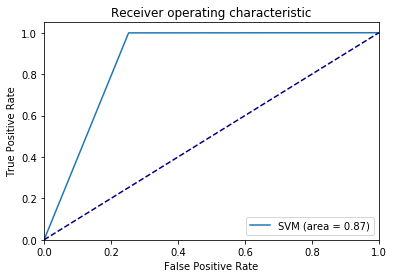

In [54]:
# Compute ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_te, y_hat)
roc_auc = auc(fpr, tpr)
svm_roc_auc = roc_auc_score(y_te, y_hat)

# plot ROC plt.figure()
#plt.plot(fpr, tpr, color='darkorange',label='ROC curve')
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.96')

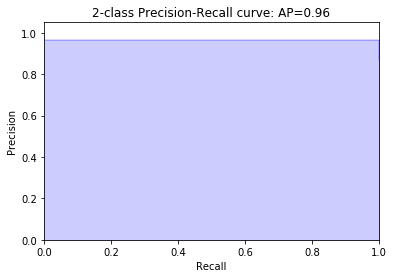

In [43]:
# Compute PR curve
from sklearn.metrics import average_precision_score 
average_precision = average_precision_score(y_te, y_hat)

from sklearn.metrics import precision_recall_curve 
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_te, y_hat)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

ROC and PR curves are also drawn above to evaluate the prediction. It can be concluded from ROC curve that ROC area is 0.87, indicating high prediction accuracy. From PR curve we can see high precision and high recall value, which means our prediction is very good.   
In conclusion, SVM is very useful to do classification in this case.

In [55]:
# use SVM to fit the model
from sklearn import svm
clf = svm.SVC(C=0.1, kernel='linear')
clf.fit(X_tr, y_tr) 

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
y_hat = clf.predict(X_te)
y_hat

array([1., 0., 1., ..., 1., 1., 1.])

In [57]:
# calculate test error
np.mean((y_hat - y_te)**2)

0.03121489475331946

In [58]:
# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_te, y_hat)

0.9687851052466805

In [69]:
coef_clf=clf.coef_[0].tolist()

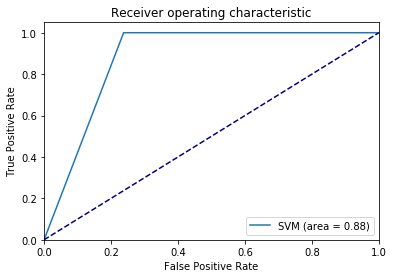

In [60]:
# Compute ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_te, y_hat)
roc_auc = auc(fpr, tpr)
svm_roc_auc = roc_auc_score(y_te, y_hat)

# plot ROC plt.figure()
#plt.plot(fpr, tpr, color='darkorange',label='ROC curve')
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.97')

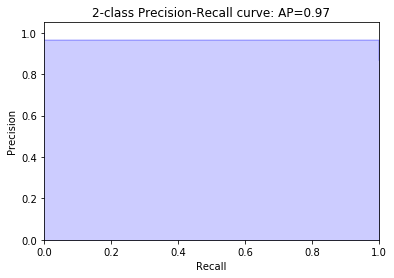

In [61]:
# Compute PR curve
from sklearn.metrics import average_precision_score 
average_precision = average_precision_score(y_te, y_hat)

from sklearn.metrics import precision_recall_curve 
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_te, y_hat)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [71]:
dict(zip(selected_X,coef_clf))

{'MORTGAGE': 5.91602585542923,
 'annual_inc': -2.9508060066369216e-05,
 'financial': 7.076019028324425e-05,
 'int_rate': 0.00010557369435701403,
 'last_pymnt_amnt': -3.3481094246520765e-06,
 'loan_amnt': 4.916309532856933e-05,
 'num_bc_tl': 5.147676146034432,
 'num_op_rev_tl': 2.7444326927444918e-05,
 'num_rev_tl_bal_gt_0': -2.79758527772255,
 'num_tl_op_past_12m': -0.00010026239298591144,
 'out_prncp': 0.0001237868977176029,
 'property': -6.348839340136973e-05,
 'recoveries': 4.0789326910182815e-05,
 'term': 9.763301907737294e-06,
 'total_bc_limit': 9.676265701617538e-06,
 'total_rec_int': 1.8589883743579136e-07,
 'total_rec_late_fee': -2.1064080911543867e-05,
 'total_rec_prncp': -7.3605349989491655}

We also try to fit SVM using linear kernel and results shows that there is subtle improvement compared with using Gaussian kernel. What is very attractive in linear kernel is that this model returns coefficients, which are weights assigned to the features. Based on these weights we can explore which predictors contribute more to the classification of loan status. It can be seen from the above that among all selected variables, __financial__, __property__, __term__, __total_bc_limit__ and __total_rec_prncp__ are variables with high weights.

### 3.2 Prediction in reality

In [72]:
import numpy as np
import pandas as pd
import os
import sqlalchemy as sqla
import sqlite3 as sql
from sqlite3 import Error
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [73]:
file_loc = os.getcwd()

In [74]:
db= sql.connect(file_loc+"\data_pred.db")
df_pred=pd.read_sql("SELECT * FROM pred",db)

In [75]:
X_pred = df_pred.drop(['loan_status'], axis = 1).values
y_pred_real = clf.predict(X_pred)

In [76]:
sum(y_pred_real == 1)/len(y_pred_real)

0.6784194372082226

Finally, SVM is used to predict the loan status in March, 2018. The results shows that SVM predict only 67% of the loan to be in good status, which is much smaller than the accuracy score of test data. Why does this happen? The data used to do prediction is very recent, say if some high weighted variables depend much on time, that loan is more likely to be classified as in bad status. For example, in prediction __total_rec_prncp__ is high weighted, which is principal received to date in meaning. It is obvious that since the loan company just released the loan and principal received to date is very small, less loans are predicted to be in good status. What can also be noticed is that variable __term__ is also with high weight, which is also about date. However, compared on prediction using random forest, this result is acceptable since there are still 67% good loans.